### VISUALIZACIÓN 1
¿Qué provincias son las más afectadas por incendios forestales?

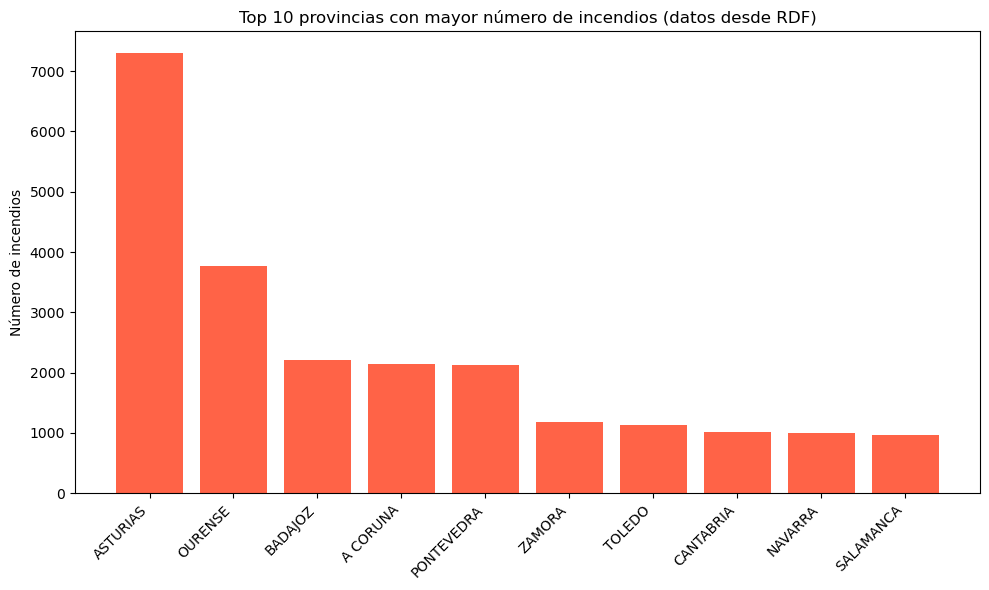

In [14]:
from rdflib import Graph, Namespace
import pandas as pd
import matplotlib.pyplot as plt

# ===============================
# 1. Cargar RDF
# ===============================
g = Graph()
g.parse("/Users/irenealavesruiz/Downloads/incendios.ttl", format="turtle")

SCHEMA = Namespace("https://schema.org/")

# ===============================
# 2. Extraer event → province
# ===============================
eventos = []
for event_uri, _, place_uri in g.triples((None, SCHEMA.location, None)):
    eventos.append(str(place_uri))

df_events = pd.DataFrame(eventos, columns=["provincia_uri"])

# Obtener nombre legible de provincia
prov_nombres = {}
for s, _, o in g.triples((None, SCHEMA.name, None)):
    prov_nombres[str(s)] = str(o).strip().upper()

df_events["provincia"] = df_events["provincia_uri"].map(prov_nombres)

# ===============================
# 3. Contar incendios por provincia
# ===============================
conteo = df_events["provincia"].value_counts().reset_index()
conteo.columns = ["provincia", "incendios"]

# Filtrar top 10
top10 = conteo.head(10)

# ===============================
# 4. Gráfica de barras
# ===============================
plt.figure(figsize=(10,6))
plt.bar(top10["provincia"], top10["incendios"], color="tomato")

plt.xticks(rotation=45, ha="right")
plt.ylabel("Número de incendios")
plt.title("Top 10 provincias con mayor número de incendios (datos desde RDF)")

plt.tight_layout()
plt.show()


### VISUALIZACIÓN 2
¿Cómo ha evolucionado el riesgo relativo de incendios en las provincias más afectadas?

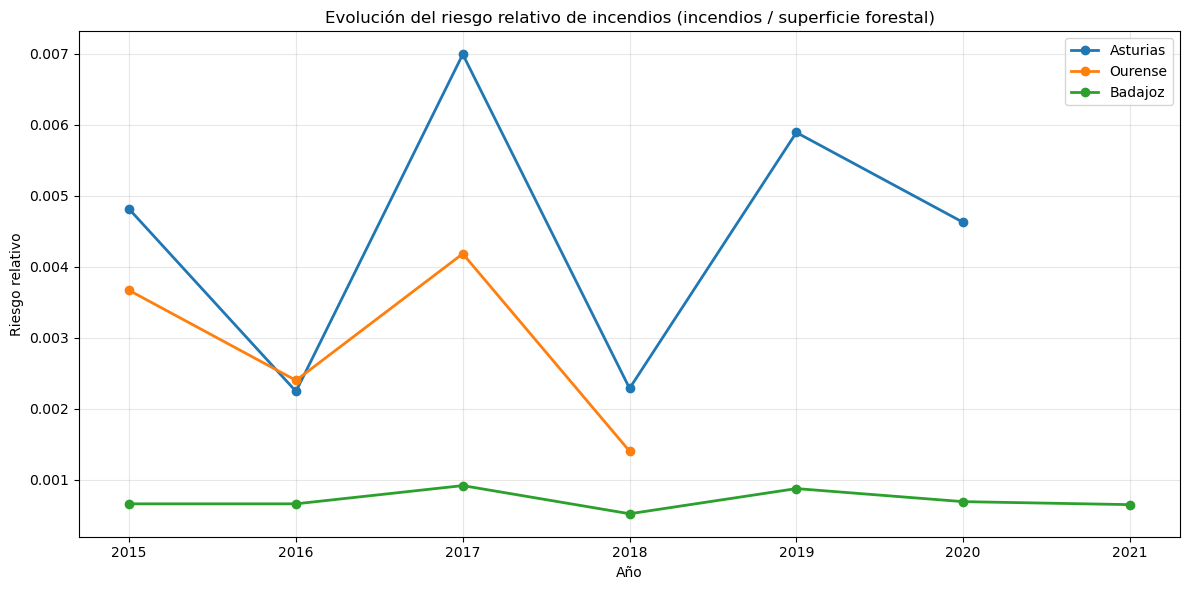

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import unicodedata

# ============================
# 1. Cargar datos (CSV con ;)
# ============================
df = pd.read_csv(
    "/Users/irenealavesruiz/Downloads/Dataset_Maestro_FINAL_DEF_V3.csv",
    sep=";",
    encoding="latin1"
)

# ============================
# 2. Normalizar provincias
# ============================
def limpiar(x):
    if pd.isna(x):
        return "DESCONOCIDO"
    x = str(x)
    x = unicodedata.normalize('NFKD', x).encode('ascii','ignore').decode('utf-8')
    return x.strip().upper()

df["Provincia"] = df["Provincia"].apply(limpiar)

# ============================
# 3. Provincias TOP 3 según RDF
# ============================
provincias_riesgo = ["ASTURIAS", "OURENSE", "BADAJOZ"]
df_sel = df[df["Provincia"].isin(provincias_riesgo)]

# ============================
# 4. Superficie forestal (IFN4 - MITECO)
# ============================
superficie_forestal = {
    "ASTURIAS": 376000,   # ha
    "OURENSE":  333000,   # ha
    "BADAJOZ":  522000    # ha
}

# ============================
# 5. Agrupar incendios por año
# ============================
incendios_anio = df_sel.groupby(["Provincia", "Anio"]).size().reset_index(name="incendios")

# Añadir superficie forestal
incendios_anio["superficie_forestal"] = incendios_anio["Provincia"].map(superficie_forestal)

# ============================
# 6. Calcular riesgo relativo
# ============================
incendios_anio["riesgo_relativo"] = (
    incendios_anio["incendios"] / incendios_anio["superficie_forestal"]
)

# ============================
# 7. Visualizar evolución temporal
# ============================
plt.figure(figsize=(12,6))

for prov in provincias_riesgo:
    df_p = incendios_anio[incendios_anio["Provincia"] == prov]
    plt.plot(
        df_p["Anio"], 
        df_p["riesgo_relativo"], 
        marker="o", 
        linewidth=2, 
        label=prov.title()
    )

plt.title("Evolución del riesgo relativo de incendios (incendios / superficie forestal)")
plt.xlabel("Año")
plt.ylabel("Riesgo relativo")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
